# Trans-effect validation: comparison with FACS screens

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy


# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection

Plotting utils

In [3]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
obs_df = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

## Read DE analysis outputs

In [4]:
# Utility to query DE results
from typing import List, Union, Optional
import anndata
import pandas as pd
import numpy as np

def get_DE_results_long(
    adata_de: anndata.AnnData, 
    targets: Union[List[str], None] = None, 
    genes: Union[List[str], None] = None, 
    effect_estimates: Union[str, List[str]] = ['log_fc', 'zscore'],
    signif_estimate: Union[None, str] = 'adj_p_value',
    signif_alpha = 0.1,
    gene_id_col: str = 'gene_name',
    target_id_col: str = 'target_contrast_gene_name',
    target_metadata_cols: List[str] = ['culture_condition', 'target_contrast']
    ):
    """
    Extract differential expression results from AnnData object in long table format.
    
    Parameters
    ----------
    adata_de : AnnData
        AnnData object containing DE results
    targets : List[str] or None
        List of target contrasts to include, or None for all
    genes : List[str] or None
        List of genes to include, or None for all
    effect_estimates : str or List[str]
        Names of layers containing effect estimates (e.g., log fold changes, z-scores)
    signif_estimate : str or None
        Name of layer containing significance values, or None if not needed
    signif_alpha : float
        Significance threshold for filtering
    gene_id_col : str
        Column in var containing gene identifiers
    target_id_col : str
        Column in obs containing target identifiers
    target_metadata_cols : List[str]
        Columns in obs to include as target metadata in the result
        
    Returns
    -------
    pd.DataFrame
        Long-format dataframe with DE results
    """
    # Convert effect_estimates to list if it's a string
    if isinstance(effect_estimates, str):
        effect_estimates = [effect_estimates]
    
    # Filter targets if specified
    if targets is not None:
        target_mask = adata_de.obs[target_id_col].isin(targets)
        adata_subset = adata_de[target_mask]
    else:
        adata_subset = adata_de
    
    # Filter genes if specified
    if genes is not None:
        gene_mask = adata_subset.var[gene_id_col].isin(genes)
        adata_subset = adata_subset[:, gene_mask]
    
    # Initialize results dataframe with proper structure
    results = None
    
    # Extract effect estimates
    for effect in effect_estimates:
        if effect not in adata_subset.layers:
            continue
            
        df = sc.get.obs_df(adata_subset, 
                          keys=adata_subset.var_names.tolist(),
                          layer=effect)
        
        # Melt to long format
        df_long = df.melt(ignore_index=False, 
                          var_name='gene', 
                          value_name=effect)
        
        # Add to results
        if results is None:
            results = df_long.reset_index()
        else:
            # Merge with existing results on index and gene
            results = results.merge(df_long.reset_index(), 
                                   on=['index', 'gene'], 
                                   how='outer')
    
    # If no valid effect estimates were found, create empty dataframe with required columns
    if results is None:
        results = pd.DataFrame(columns=['index', 'gene'] + effect_estimates)
    
    # Add significance values if requested
    if signif_estimate is not None and signif_estimate in adata_subset.layers:
        signif_df = sc.get.obs_df(adata_subset, 
                                 keys=adata_subset.var_names.tolist(),
                                 layer=signif_estimate)
        
        # Melt to long format
        signif_long = signif_df.melt(ignore_index=False, 
                                    var_name='gene', 
                                    value_name=signif_estimate)
        
        # Add to results
        results = results.merge(signif_long.reset_index()[['index', 'gene', signif_estimate]], 
                               on=['index', 'gene'], 
                               how='left')
        
        # Add significance indicator
        results['significant'] = results[signif_estimate] < signif_alpha
    
    # Add gene metadata
    gene_meta = adata_subset.var[[gene_id_col]].reset_index()
    results = results.merge(gene_meta, left_on='gene', right_on='index', suffixes=('', '_gene'))
    results = results.drop('index_gene', axis=1)
    
    # Add target metadata
    if target_id_col not in target_metadata_cols:
        target_metadata_cols.append(target_id_col)
    target_meta = adata_subset.obs[target_metadata_cols].reset_index()
    results = results.merge(target_meta, left_on='index', right_on='index')
    
    return results

In [5]:
adata_de = sc.read_h5ad(datadir + f'/DE_results/{experiment_name}.merged_DE_results.h5ad')
adata_de

AnnData object with n_obs × n_vars = 6484 × 8833
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'mt'
    layers: 'MASH_PosteriorMean', 'MASH_PosteriorSD', 'MASH_lfsr', 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value'

In [6]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

In [7]:
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

Exclude from analysis genes with very low base mean across conditions

In [8]:
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T

adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1)

adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim.mean(1)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim.std(1)

# Exclude from analysis genes with very low base mean across conditions
gs_mask = (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Rest'] > 0.1) 
adata_de = adata_de[:, gs_mask].copy()

## Process FACS screen results

In [9]:
def get_mageck_pval(df, lfc_col='neg|lfc', pos_pval_col='pos|p-value', neg_pval_col='neg|p-value'):
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    result_df['pvalue'] = np.nan
    
    for idx, row in result_df.iterrows():
        log_fc = row[lfc_col]
        
        # Select the appropriate p-value based on the direction of log_fc
        if log_fc > 0:
            p_value = row[pos_pval_col]
        elif log_fc < 0:
            p_value = row[neg_pval_col]
        else:
            # If log_fc is exactly 0, standard error is undefined
            continue
        
        # Convert p-value to z-score (handling potential invalid p-values)
        if 0 <= p_value < 1:
            result_df.at[idx, 'pvalue'] = p_value
    
    return result_df

In [10]:
keep_mageck_columns = ['target', 'effect_size', 'num', 'neg|goodsgrna',
       'pos|goodsgrna', 'pvalue', 'phenotype', 'perturbation_type', 'downstream_gene']

In [11]:
Schmidt2022_data = pd.read_csv('/mnt/oak/users/emma/data/CRISPR_screens/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv', index_col=0)
Schmidt2022_data['phenotype'] = np.where(Schmidt2022_data['phenotype'] == 'Prim.CRi.CD4.IL2', 'CD4+ IL2', 'CD8+ IFNg')
Schmidt2022_data['downstream_gene'] = np.where(Schmidt2022_data['phenotype'] == 'CD4+ IL2', 'IL2', 'IFNG')
Schmidt2022_data = Schmidt2022_data[keep_mageck_columns].copy()
Schmidt2022_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
37860,VAV1,-2.9160,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37861,LCP2,-1.8811,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37862,CD3G,-2.6665,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37863,IL2,-2.6101,12,11,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37864,CD3D,-2.4943,12,10,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2


In [12]:
# Supplementary table 8
FOXP3_data = pd.read_csv('../../metadata/Umhoefer2025_FOXP3_Teff.csv')
FOXP3_data['perturbation_type'] = 'CRISPRn'
FOXP3_data['phenotype'] = 'CD4+ FOXP3'
FOXP3_data['downstream_gene'] = 'FOXP3'
FOXP3_data = get_mageck_pval(FOXP3_data)
FOXP3_data = FOXP3_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size'}, axis=1)[keep_mageck_columns]
FOXP3_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,Non-Targeting,0.00000,593,0,0,NaN,CD4+ FOXP3,CRISPRn,FOXP3
1,FOXO1,1.82020,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
2,PTEN,1.13060,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
3,GATA3,1.39490,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
4,NFKB2,0.97018,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3


In [13]:
# Freimer 2022 - Supplementary table 2
Fremer_IL2RA_data = pd.read_csv('../../metadata/Freimer2022_Screen.csv')
Fremer_IL2RA_data['perturbation_type'] = 'CRISPRn'
Fremer_IL2RA_data['downstream_gene'] = Fremer_IL2RA_data['screen'].copy()
# FOXP3_data['phenotype'] = 'CD4+ FOXP3'
Fremer_IL2RA_data = get_mageck_pval(Fremer_IL2RA_data)
Fremer_IL2RA_data = Fremer_IL2RA_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size', 'screen':'phenotype'}, axis=1)[keep_mageck_columns]
Fremer_IL2RA_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,Non-Targeting,0.0000,593,0,0,NaN,IL2RA,CRISPRn,IL2RA
1,IL2RA,2.6818,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
2,STAT5B,2.3375,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
3,FOXP1,1.6035,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
4,STAT5A,1.2474,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA


In [14]:
# Arce 2025 - Supplementary table 1
Arce_IL2RA_data = pd.read_csv('../../metadata/Arce2025_Screen.csv')
# Melt the dataframe to convert columns with suffixes into a longer format
# Identify columns with suffixes like '.Resting_Teff', '.Resting_Treg'
suffixes = [col.split('.')[-1] for col in Arce_IL2RA_data.columns if '.' in col]
suffixes = list(set(suffixes))  # Get unique suffixes

# Create a list to store melted dataframes for each suffix
melted_dfs = []

for suffix in suffixes:
    # Get columns for this suffix
    suffix_cols = [col for col in Arce_IL2RA_data.columns if col.endswith('.' + suffix)]
    # Get base columns (without suffix)
    base_cols = [col.split('.')[0] for col in suffix_cols]
    
    # Create a subset with id and columns for this suffix
    subset = Arce_IL2RA_data[['id'] + suffix_cols].copy()
    # Rename columns to remove suffix
    rename_dict = {suffix_cols[i]: base_cols[i] for i in range(len(suffix_cols))}
    subset = subset.rename(columns=rename_dict)
    # Add condition column
    subset['phenotype'] = suffix
    
    melted_dfs.append(subset)

# Combine all melted dataframes
long_Arce_data = pd.concat(melted_dfs, ignore_index=True)
long_Arce_data['phenotype'] = long_Arce_data['phenotype'].astype(str) + '_IL2RA'
long_Arce_data['downstream_gene'] = 'IL2RA'
long_Arce_data['perturbation_type'] = 'CRISPRi'
# FOXP3_data['phenotype'] = 'CD4+ FOXP3'
long_Arce_data = get_mageck_pval(long_Arce_data)
long_Arce_data.head()
long_Arce_data = long_Arce_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size', 'screen':'phenotype'}, axis=1)[keep_mageck_columns]
long_Arce_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,STAT5B,2.15140,4,0,4,0.000004,Stimulated_Teff_IL2RA,CRISPRi,IL2RA
1,IL2RA,3.41680,4,0,4,0.000004,Stimulated_Teff_IL2RA,CRISPRi,IL2RA
2,PTEN,0.77117,4,0,4,0.000004,Stimulated_Teff_IL2RA,CRISPRi,IL2RA
3,STAT5A,0.96477,4,0,4,0.000004,Stimulated_Teff_IL2RA,CRISPRi,IL2RA
4,FOXP1,0.81889,4,0,4,0.000004,Stimulated_Teff_IL2RA,CRISPRi,IL2RA


In [83]:
all_FACS_data[(all_FACS_data['dataset'] == 'Freimer2022') & (all_FACS_data['phenotype'] == 'IL2RA')].sort_values('effect_size')

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene,dataset
40055,MED12,-3.2280,4,4,0,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
40053,CBFB,-2.9785,4,4,0,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
40054,HIVEP2,-2.2874,4,4,0,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
40048,KLF2,-2.1791,4,4,0,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
40052,MYB,-1.9568,4,4,0,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
...,...,...,...,...,...,...,...,...,...,...
38709,STAT5A,1.2474,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
38710,GATA3,1.3861,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
38708,FOXP1,1.6035,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022
38707,STAT5B,2.3375,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA,Freimer2022


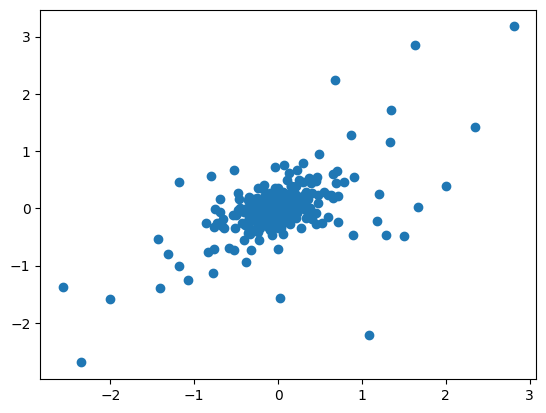

In [ ]:
plt.scatter(
    Arce_IL2RA_data['neg|lfc.Resting_Treg'],
    Arce_IL2RA_data['neg|lfc.Resting_Teff'])

In [20]:
# Concatenate all FACS tables into one dataframe
# First, add a source column to each dataframe to track the origin
Schmidt2022_data['dataset'] = 'Schmidt2022'
FOXP3_data['dataset'] = 'Umhoefer2025'
Fremer_IL2RA_data['dataset'] = 'Freimer2022'
long_Arce_data['dataset'] = 'Arce2025'

# Concatenate all dataframes
all_FACS_data = pd.concat([
    Schmidt2022_data,
    FOXP3_data,
    Fremer_IL2RA_data,
    long_Arce_data
], ignore_index=True)

# Display the first few rows to verify the concatenation
print(f"Combined FACS data shape: {all_FACS_data.shape}")
all_FACS_data.head()


Combined FACS data shape: (46811, 10)


,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene,dataset
0,VAV1,-2.9160,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
1,LCP2,-1.8811,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
2,CD3G,-2.6665,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
3,IL2,-2.6101,12,11,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
4,CD3D,-2.4943,12,10,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022


In [93]:
cond = 'Stim8hr'
gene = 'IL2RA'
FACS_gene_id = adata_de.var_names[adata_de.var['gene_name'] == gene].tolist()[0]
effect_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='zscore')
effect_on_facs_gene.sort_values(FACS_gene_id).set_index('target_contrast_gene_name').loc['GATA3']

n_cells_target     65.000000
ENSG00000134460    -0.282042
Name: GATA3, dtype: float64

In [98]:
adata_de.var[adata_de.var.gene_name == 'IFNG']

,gene_ids,gene_name,mt,n_signif_effects_Rest,n_mash_signif_effects_Rest,n_signif_effects_Stim8hr,n_mash_signif_effects_Stim8hr,mean_baseMean_Rest,std_baseMean_Rest,mean_baseMean_Stim8hr,std_baseMean_Stim8hr
ENSG00000111537,ENSG00000111537,IFNG,False,19,14,8,3,1.780599,0.080882,322.578453,4.468692


In [65]:
def compare_facs_to_perturbseq(adata_de, FACS_phenotype_df, phenotype, gene, cond, min_cells=50, facs_pval_threshold=0.05, perturbseq_pval_threshold=0.1, ax=None):
    """
    Compare FACS screen results with perturb-seq data for a specific gene and condition.
    
    Parameters:
    -----------
    adata_de : AnnData
        AnnData object containing differential expression results
    FACS_phenotype_df : pandas.DataFrame
        DataFrame containing FACS screen results
    phenotype : str
        The phenotype column value to filter from FACS data
    gene : str
        Gene symbol to analyze
    cond : str
        Culture condition to filter from adata_de
    min_cells : int, default=50
        Minimum number of cells required for a target
    facs_pval_threshold : float, default=0.05
        P-value threshold for FACS significance
    perturbseq_pval_threshold : float, default=0.1
        P-value threshold for perturb-seq significance
    ax : matplotlib.axes.Axes, default=None
        Axes object to plot on. If None, a new figure is created.
        
    Returns:
    --------
    tuple
        (plot_dataframe, correlation_all, correlation_significant, p_value)
    """
    # Get gene ID from gene name
    FACS_gene_id = adata_de.var_names[adata_de.var['gene_name'] == gene].tolist()[0]
    
    # Extract perturb-seq data for the gene
    effect_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='zscore')
    effect_on_facs_gene.columns = ['target', 'n_cells_target', 'perturbseq_log_fc']
    
    signif_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='adj_p_value')
    signif_on_facs_gene.columns = ['target', 'n_cells_target', 'perturbseq_pval']
    effect_on_facs_gene = pd.merge(effect_on_facs_gene, signif_on_facs_gene)
    
    # Extract FACS data for the phenotype
    facs_effect = FACS_phenotype_df.pivot(index='target', columns='phenotype', values='effect_size')[phenotype].reset_index()
    facs_effect.columns = ['target', 'facs_screen_zscore']
    facs_signif = FACS_phenotype_df.pivot(index='target', columns='phenotype', values='pvalue')[phenotype].reset_index()
    facs_signif.columns = ['target', 'facs_screen_pval']
    facs_effect = pd.merge(facs_effect, facs_signif)
    
    # Merge datasets
    pl_df = pd.merge(facs_effect, effect_on_facs_gene)
    pl_df = pl_df.dropna()
    
    # Add significance annotations
    pl_df['facs_significant'] = pl_df['facs_screen_pval'] < facs_pval_threshold
    pl_df['perturbseq_significant'] = pl_df['perturbseq_pval'] < perturbseq_pval_threshold
    pl_df = pl_df[pl_df['n_cells_target'] > min_cells]
    
    # Calculate correlation coefficient for all genes
    corr_all = pl_df['facs_screen_zscore'].corr(pl_df['perturbseq_log_fc'])
    
    # Calculate correlation coefficient for significant genes
    sig_genes = pl_df[pl_df['facs_significant']]
    corr_sig = sig_genes['facs_screen_zscore'].corr(sig_genes['perturbseq_log_fc']) if len(sig_genes) > 1 else float('nan')
    
    # Calculate p-value for correlation of all genes
    from scipy import stats
    _, p_value = stats.pearsonr(pl_df['facs_screen_zscore'], pl_df['perturbseq_log_fc'])
    
    # Calculate p-value for correlation of significant genes
    if len(sig_genes) > 1:
        _, p_value_sig = stats.pearsonr(sig_genes['facs_screen_zscore'], sig_genes['perturbseq_log_fc'])
    else:
        p_value_sig = float('nan')
    
    # Get dataset name from the FACS data
    dataset_name = FACS_phenotype_df[FACS_phenotype_df['phenotype'] == phenotype]['dataset'].iloc[0]
    
    # Create figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Add dotted lines at x=0 and y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Plot non-significant points first
    sns.scatterplot(data=pl_df, 
                    x='facs_screen_zscore', y='perturbseq_log_fc', 
                    color='black', edgecolor='none', s=6, 
                    label=f'All regulators (n={len(pl_df[~pl_df["facs_significant"]])}) - r = {corr_all:.2f}, p = {p_value:.2e}',
                    ax=ax)
    
    # Plot significant points on top with different color
    sns.scatterplot(data=pl_df[pl_df['facs_significant']], 
                    x='facs_screen_zscore', y='perturbseq_log_fc', 
                    color='red', edgecolor='none', s=12, 
                    label=f'FACS significant (n={len(sig_genes)}) - r = {corr_sig:.2f}, p = {p_value_sig:.2e}' if not np.isnan(corr_sig) else 'Significant genes: insufficient data',
                    ax=ax)
    
    # Set axis labels with dataset information
    ax.set_xlabel(f'FACS screen logFC ({phenotype} - {dataset_name})', fontsize=14)
    ax.set_ylabel(f'Perturb-seq z-score ({gene})', fontsize=14)
    # Create legend with correlation information
    legend_text = [
        f'All regulators (n={len(pl_df[~pl_df["facs_significant"]])}) - r = {corr_all:.2f}, p = {p_value:.2e}',
        f'FACS significant (n={len(sig_genes)}) - r = {corr_sig:.2f}, p = {p_value_sig:.2e}' if not np.isnan(corr_sig) else 'Significant genes: insufficient data'
    ]
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=legend_text[0]),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=legend_text[1])
    ]
    
    # Add legend outside the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=12)
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    return pl_df, corr_all, corr_sig, p_value


In [66]:
# Convert the dataframe to a list of tuples
phenotype_gene_pairs = list(all_FACS_data[['phenotype', 'downstream_gene']].drop_duplicates().itertuples(index=False, name=None))


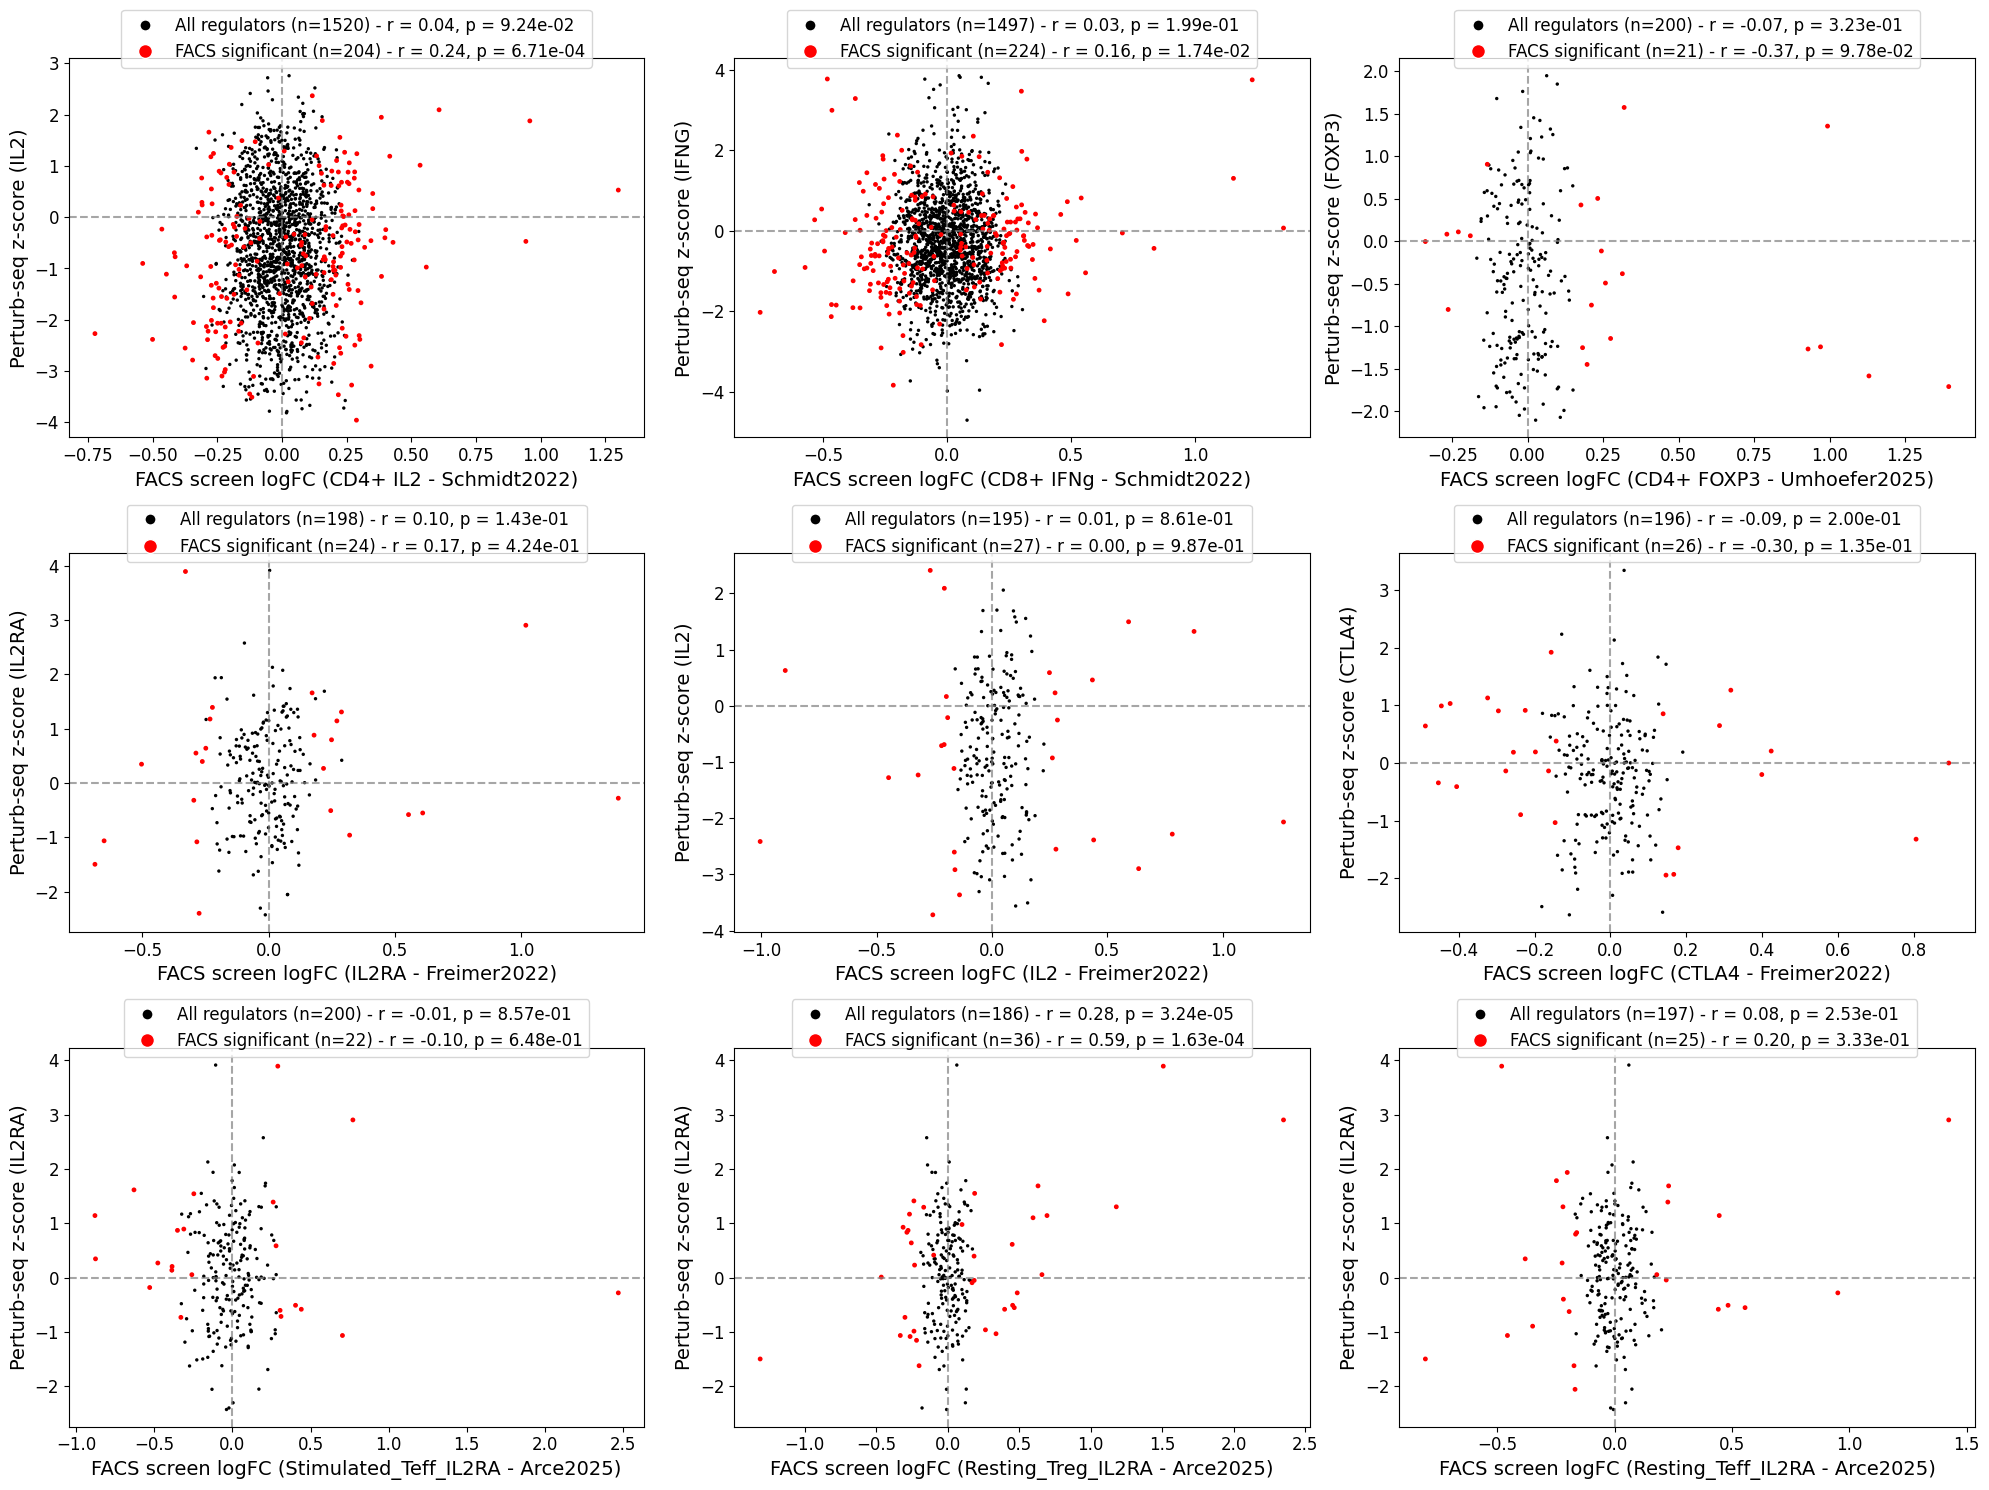

In [69]:
# Calculate the number of rows needed for a 3-column layout
num_pairs = len(phenotype_gene_pairs)
num_rows = (num_pairs + 2) // 3  # Ceiling division to ensure all pairs fit

# Create a figure with 3 columns and enough rows to fit all phenotype-gene pairs
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each phenotype-gene pair in its own subplot
for i, (p, g) in enumerate(phenotype_gene_pairs):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        pl_df, corr_all, corr_sig, p_value = compare_facs_to_perturbseq(
            adata_de, 
            all_FACS_data, 
            phenotype=p, 
            gene=g,
            cond='Stim8hr',
            ax=axes[i]
        )

# Hide any unused subplots
for j in range(num_pairs, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()

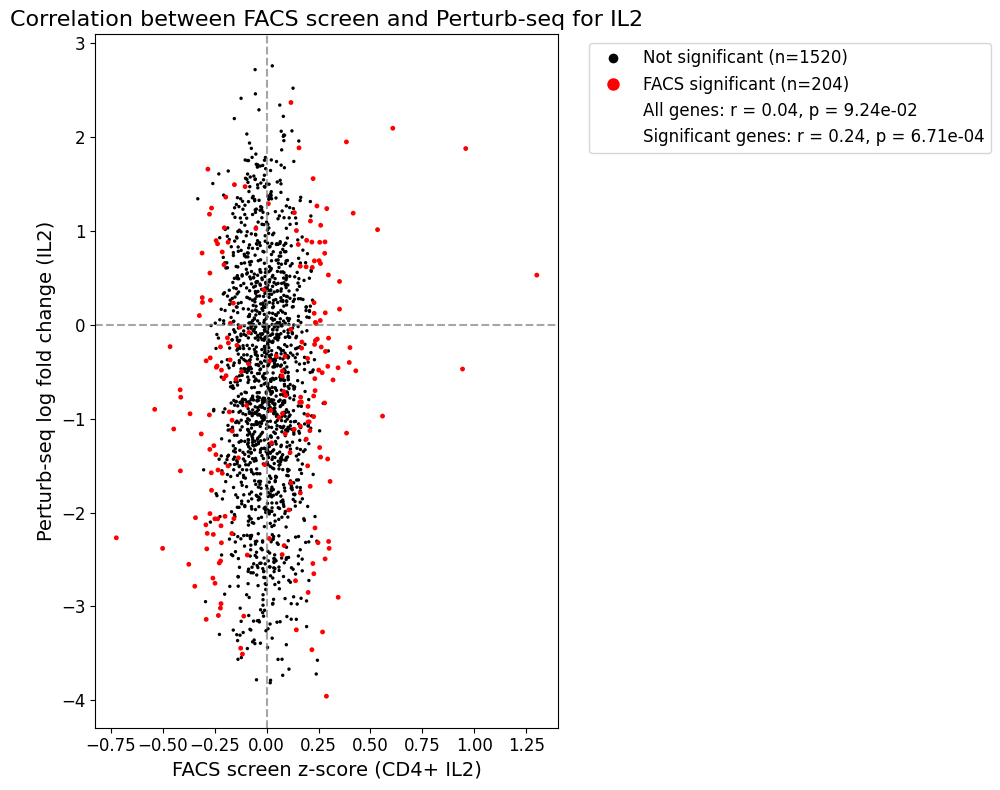

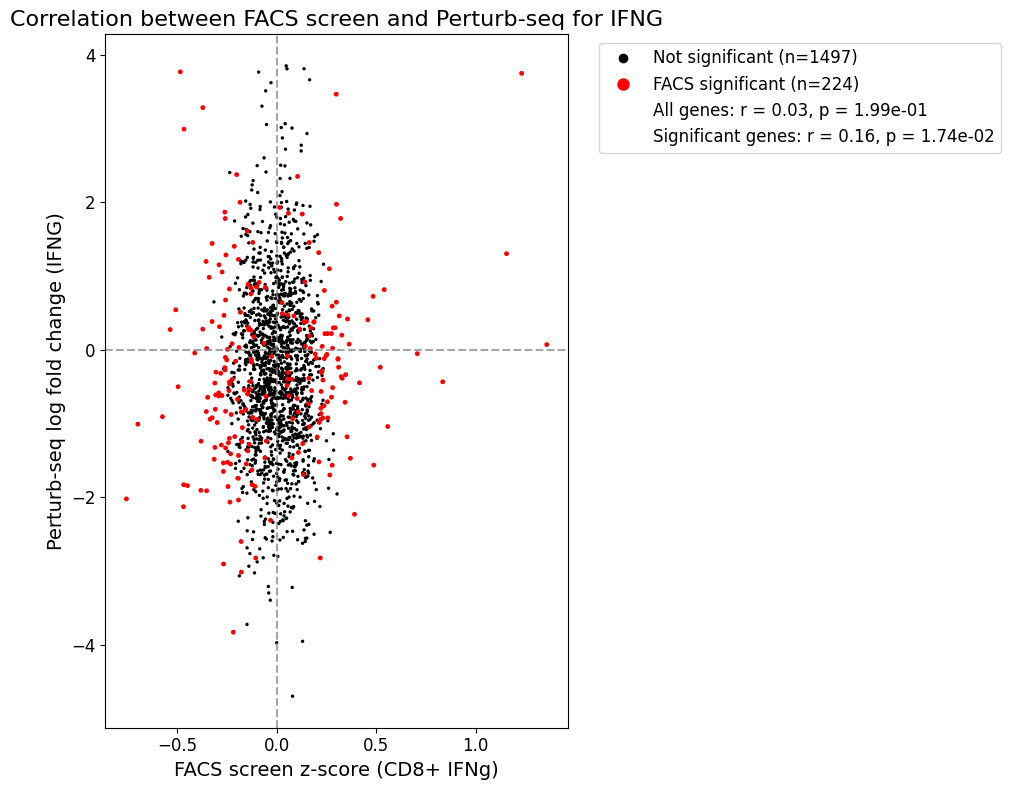

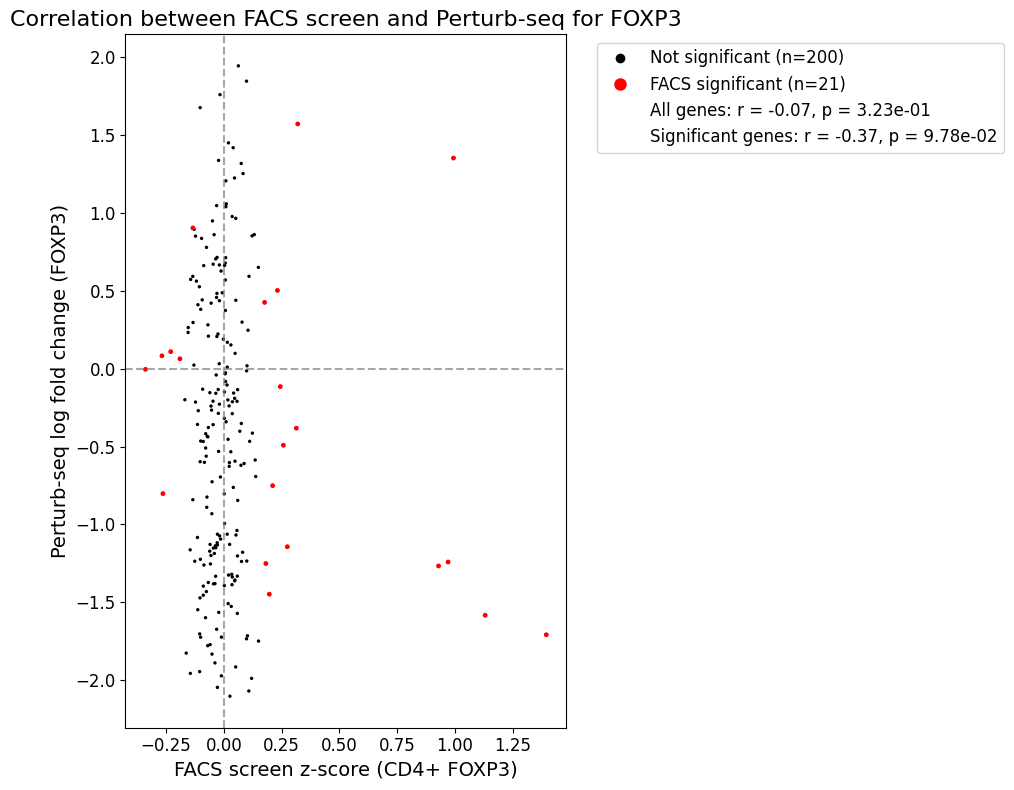

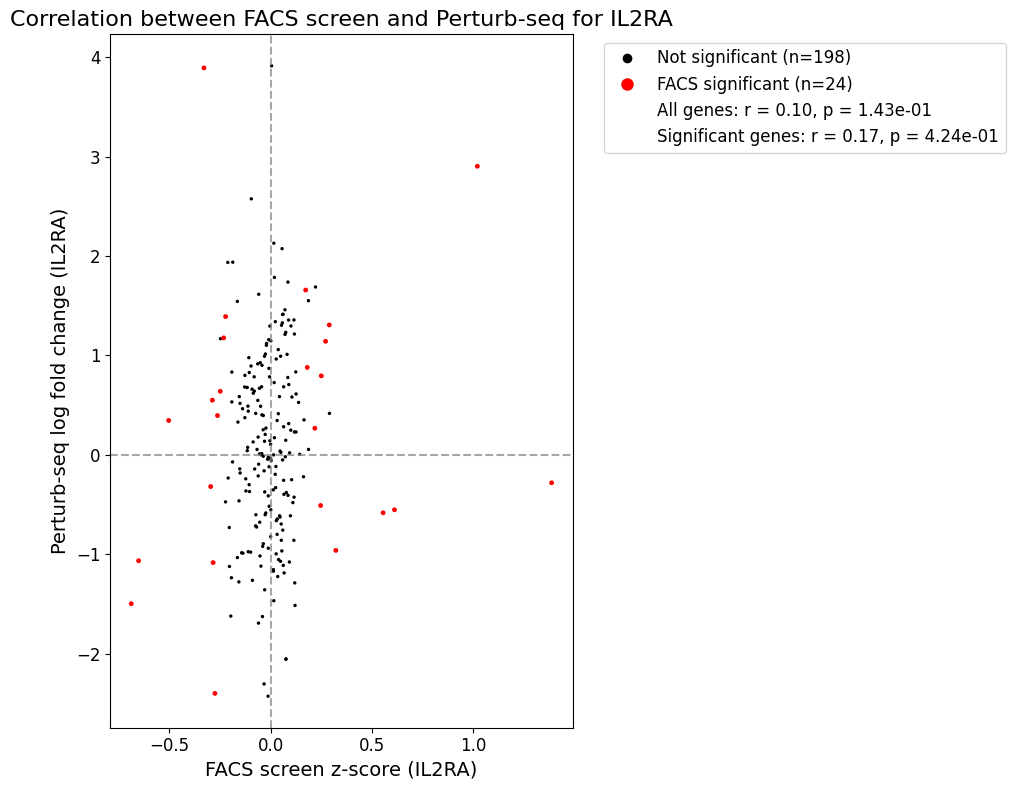

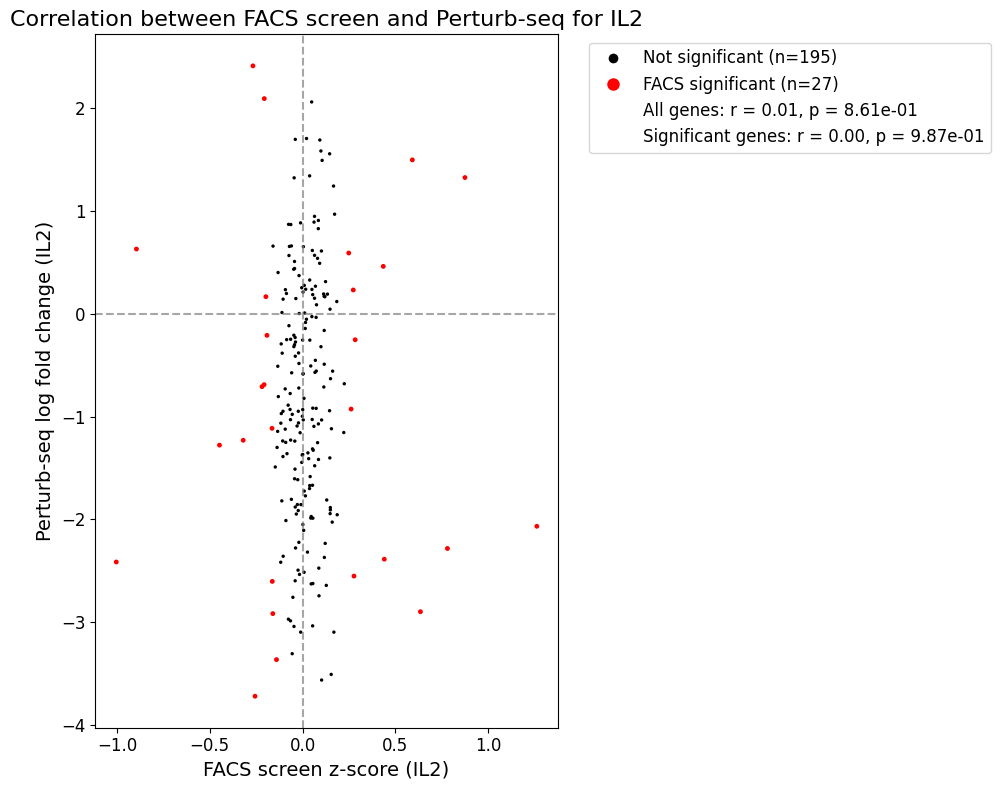

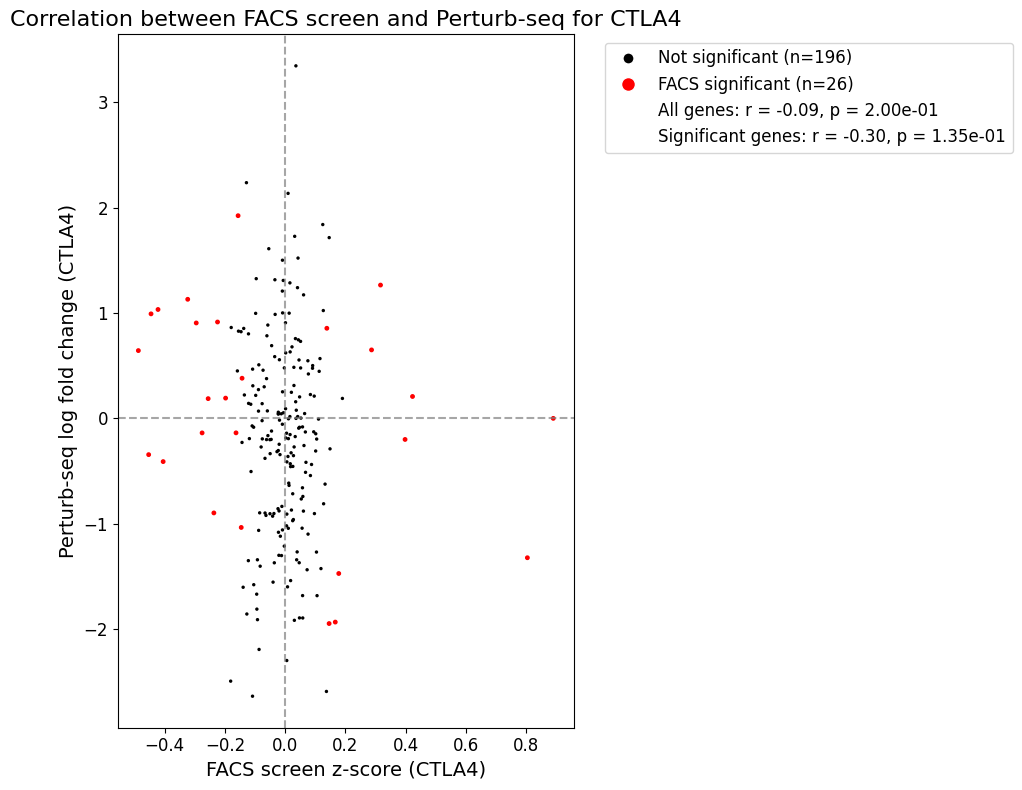

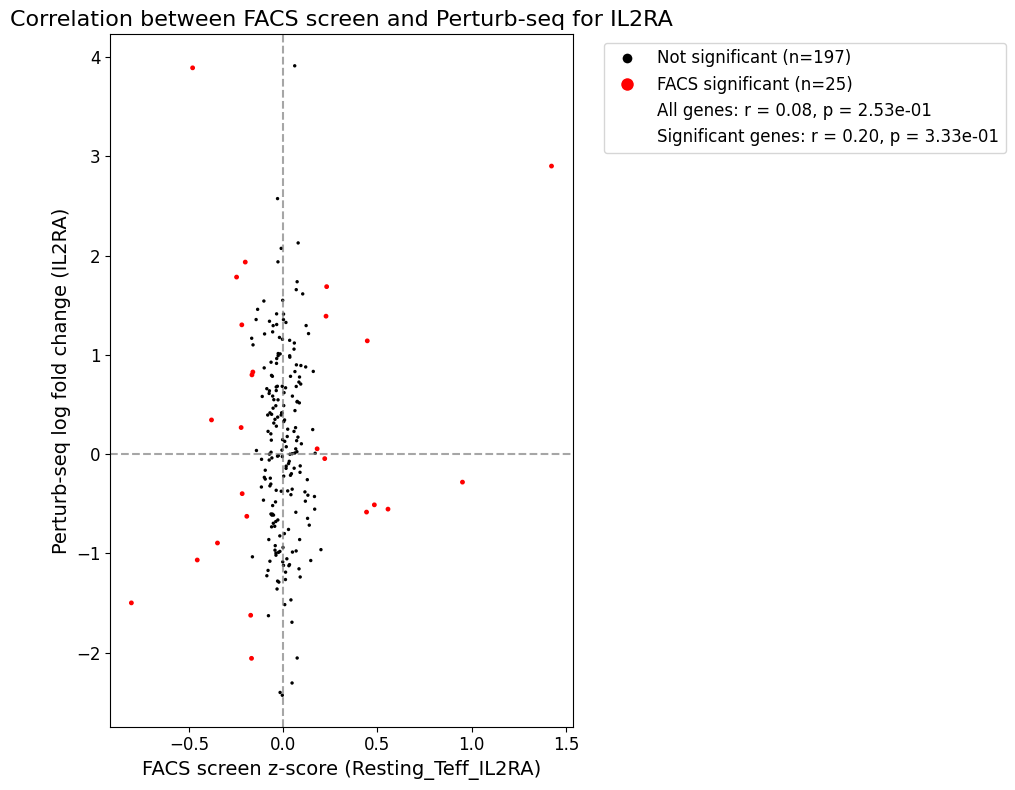

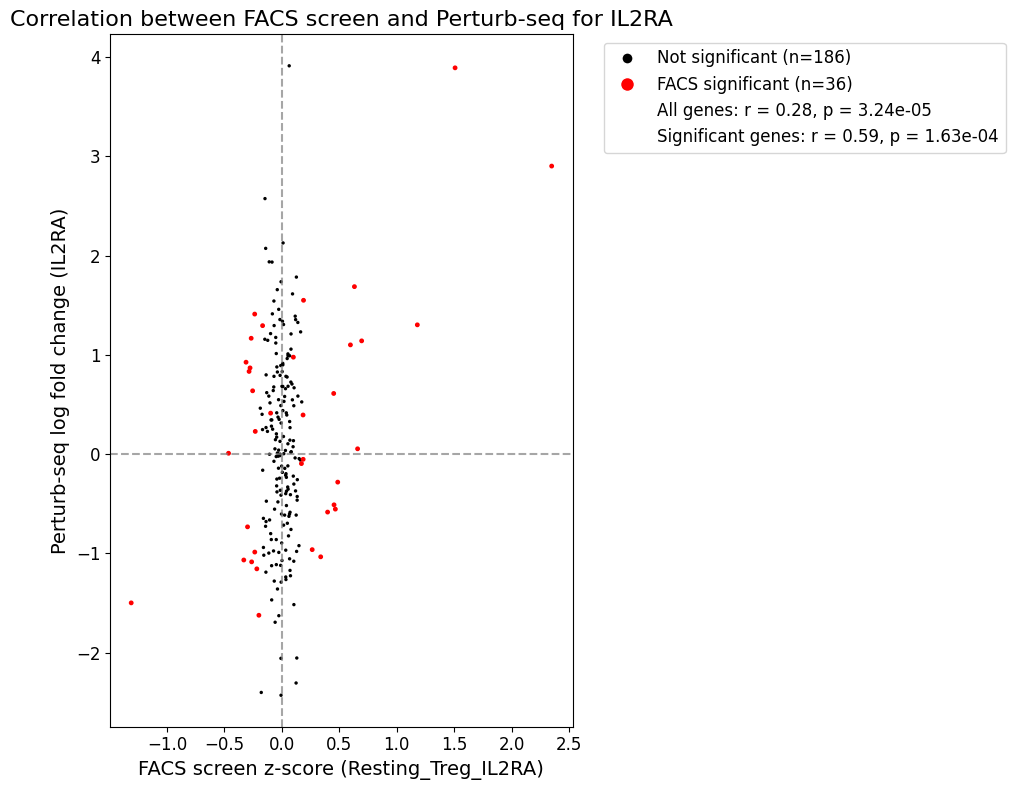

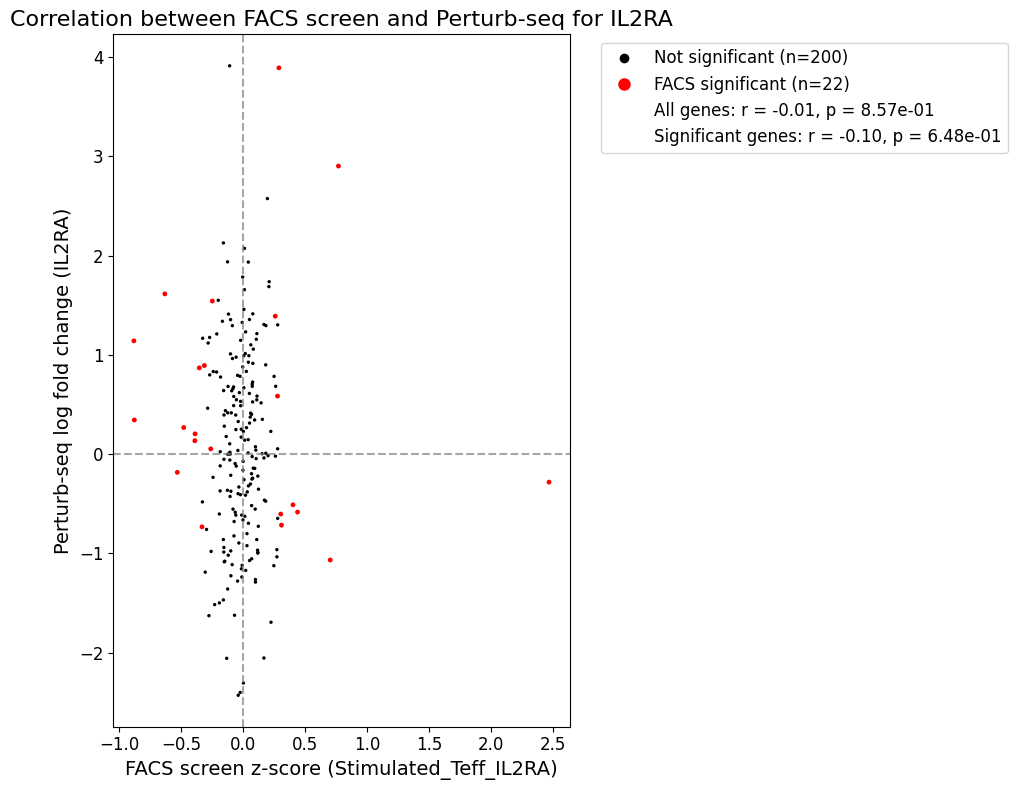

In [39]:
for p, g in phenotype_gene_pairs:
    pl_df, corr_all, corr_sig, p_value = compare_facs_to_perturbseq(
        adata_de, 
        all_FACS_data, 
        phenotype=p, 
        gene = g,
        cond = 'Stim8hr'
    )

In [82]:
all_FACS_data

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene,dataset,neg_hit,pos_hit,hit
0,VAV1,-2.9160,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022,True,False,neg_hit
1,LCP2,-1.8811,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022,True,False,neg_hit
2,CD3G,-2.6665,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022,True,False,neg_hit
3,IL2,-2.6101,12,11,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022,True,False,neg_hit
4,CD3D,-2.4943,12,10,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022,True,False,neg_hit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46806,MYB,-1.3944,4,4,0,3.660000e-06,Resting_Teff_IL2RA,CRISPRi,IL2RA,Arce2025,True,False,neg_hit
46807,HIVEP2,-1.5677,4,4,0,3.660000e-06,Resting_Teff_IL2RA,CRISPRi,IL2RA,Arce2025,True,False,neg_hit
46808,MED12,-2.2103,4,4,0,3.660000e-06,Resting_Teff_IL2RA,CRISPRi,IL2RA,Arce2025,True,False,neg_hit
46809,CBFB,-2.6935,4,4,0,3.660000e-06,Resting_Teff_IL2RA,CRISPRi,IL2RA,Arce2025,True,False,neg_hit


In [83]:
phenotype_gene_pairs = list(all_FACS_data[['phenotype', 'downstream_gene']].drop_duplicates().itertuples(index=False, name=None))
all_facs_targets = all_FACS_data['target'].unique()

perturb_seq_effect = get_DE_results_long(adata_de, 
    targets=all_facs_targets,  
    genes=all_FACS_data['downstream_gene'].unique(), 
    effect_estimates=['MASH_PosteriorMean', 'log_fc', 'zscore'],
    target_metadata_cols=['culture_condition']).rename(
    {'target_contrast_gene_name':'target', 'gene_name':'downstream_gene'}, axis=1
)[['target', 'downstream_gene','zscore', 'adj_p_value', 'culture_condition']]

all_FACS_data['neg_hit'] = (all_FACS_data['pvalue'] < 0.05) & (all_FACS_data['effect_size'] < 0)
all_FACS_data['pos_hit'] = (all_FACS_data['pvalue'] < 0.05) & (all_FACS_data['effect_size'] > 0)
all_FACS_data['hit'] = np.where(all_FACS_data['pos_hit'], 'pos_hit', np.where(all_FACS_data['neg_hit'], 'neg_hit', 'not_hit'))

merged_data = pd.merge(perturb_seq_effect, all_FACS_data[['phenotype','hit','pos_hit', 'neg_hit', 'target', 'downstream_gene', 'dataset', 'effect_size']], how='left').dropna()
merged_data.head()

,target,downstream_gene,zscore,adj_p_value,culture_condition,phenotype,hit,pos_hit,neg_hit,dataset,effect_size
1,AKAP2,IL2,0.772391,0.999999,Rest,CD4+ IL2,not_hit,False,False,Schmidt2022,-0.163590
2,AKAP2,IFNG,-1.106448,0.999999,Rest,CD8+ IFNg,not_hit,False,False,Schmidt2022,-0.015136
6,AKAP2,IL2,-1.115752,0.999985,Stim8hr,CD4+ IL2,not_hit,False,False,Schmidt2022,-0.163590
7,AKAP2,IFNG,-1.487482,0.999985,Stim8hr,CD8+ IFNg,not_hit,False,False,Schmidt2022,-0.015136
11,DPM1,IL2,-0.858375,0.998866,Rest,CD4+ IL2,not_hit,False,False,Schmidt2022,-0.194340


/tmp/ipykernel_2667100/802777252.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=hit_subset, x='phenotype', y='zscore', hue='hit',
/tmp/ipykernel_2667100/802777252.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=hit_subset, x='phenotype', y='zscore', hue='hit',
/tmp/ipykernel_2667100/802777252.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=hit_subset, x='phenotype', y='zscore', hue='hit',
/tmp/ipykernel_2667100/802777252.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(dat

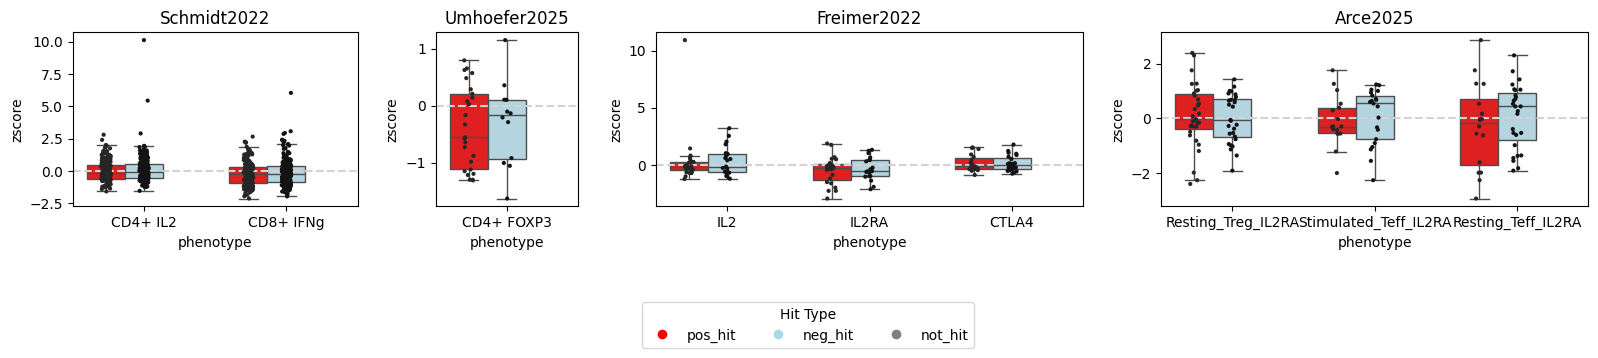

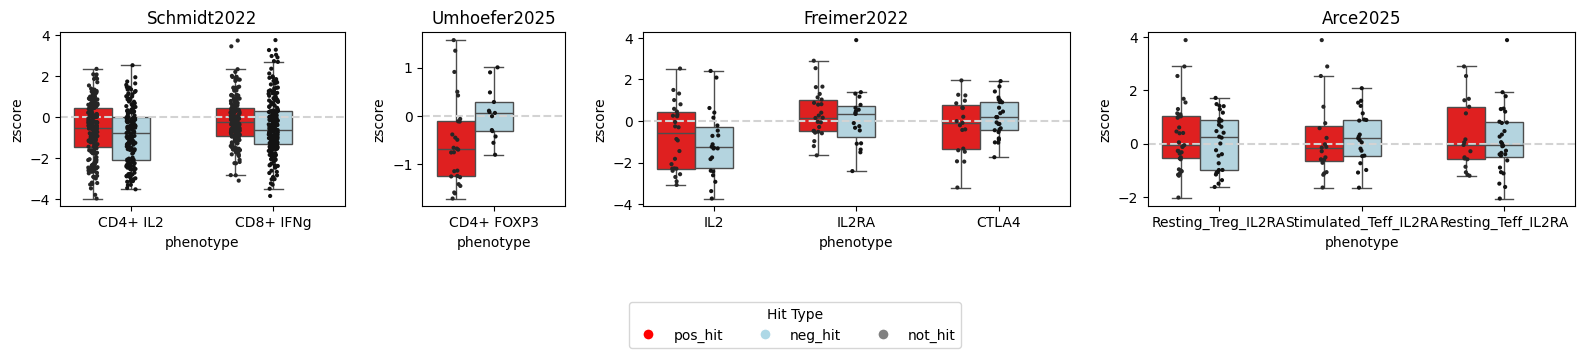

In [80]:
hit_colors = {'pos_hit': 'red', 'neg_hit': 'lightblue', 'not_hit': 'grey'}
for cond in ['Rest', 'Stim8hr']:
    # Create a figure with subplots based on the number of datasets
    datasets = merged_data.dataset.unique()
    n_datasets = len(datasets)

    # Calculate the width of each subplot based on the number of downstream genes
    subplot_widths = []
    for d in datasets:
        subset = merged_data[merged_data.dataset == d]
        n_genes = len(subset['phenotype'].unique())
        subplot_widths.append(n_genes)

    # Normalize widths to sum to total figure width
    total_width = 4 * n_datasets
    width_ratios = [w/sum(subplot_widths) * total_width for w in subplot_widths]

    fig, axes = plt.subplots(1, n_datasets, figsize=(total_width, 3), sharey=False, 
                            gridspec_kw={'width_ratios': width_ratios})

    # If there's only one dataset, axes won't be an array
    if n_datasets == 1:
        axes = [axes]
    
    # Define the order of hit types to ensure consistency
    hit_order = ['pos_hit', 'neg_hit', 'not_hit']

    for i, d in enumerate(datasets):
        subset = merged_data[(merged_data.dataset == d) & (merged_data.culture_condition == cond) & (merged_data.hit != 'not_hit')]
        
        # First plot all data points including not_hit
        sns.boxplot(data=subset, x='phenotype', y='zscore', hue='hit', 
                    palette=hit_colors, ax=axes[i], showfliers=False, hue_order=hit_order)
        
        # Then plot only the hits to make them more visible
        hit_subset = subset[subset.hit != 'not_hit']
        sns.stripplot(data=hit_subset, x='phenotype', y='zscore', hue='hit', 
                    dodge=True, s=3, color='black', ax=axes[i], hue_order=hit_order)
        
        axes[i].axhline(0, linestyle='--', color='lightgrey')
        axes[i].set_title(d)
        
        # Remove all legends as we'll create a single one outside
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()

    # Create a single legend outside the plots with consistent order
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=hit_colors[hit], 
                         markersize=8, label=hit) for hit in hit_order]
    fig.legend(handles=handles, labels=hit_order, loc='upper center', 
               bbox_to_anchor=(0.5, 0), ncol=len(hit_colors), title="Hit Type", frameon=True)
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make room for the legend

Correlation between zscore and effect_size by group:


/tmp/ipykernel_2667100/2785283308.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_results = numeric_data.groupby(['dataset', 'phenotype', 'culture_condition']).apply(
/tmp/ipykernel_2667100/2785283308.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = numeric_data.groupby(['dataset', 'phenotype', 'culture_condition']).apply(


,dataset,phenotype,culture_condition,correlation,p_value
12,Arce2025,Resting_Teff_IL2RA,Rest,-0.002786,0.985852
13,Arce2025,Resting_Teff_IL2RA,Stim8hr,0.185284,0.223023
14,Arce2025,Resting_Treg_IL2RA,Rest,0.258432,0.048121
15,Arce2025,Resting_Treg_IL2RA,Stim8hr,0.399618,0.001420
16,Arce2025,Stimulated_Teff_IL2RA,Rest,-0.054083,0.747081
17,Arce2025,Stimulated_Teff_IL2RA,Stim8hr,-0.031996,0.844614
24,Freimer2022,CTLA4,Rest,0.053977,0.731017
25,Freimer2022,CTLA4,Stim8hr,-0.417177,0.004358
26,Freimer2022,IL2,Rest,0.068733,0.653698
27,Freimer2022,IL2,Stim8hr,-0.023335,0.874907


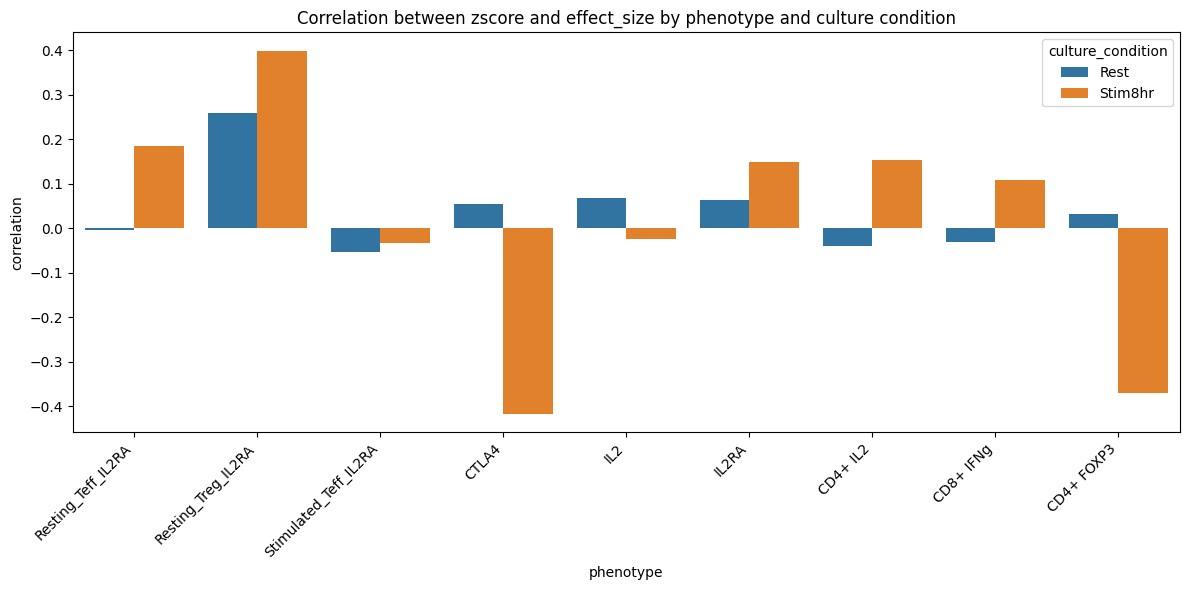

In [94]:
# Calculate correlation between zscore and effect_size for each group
# Convert any non-numeric values to NaN first to avoid conversion errors
numeric_data = merged_data[merged_data['hit'] != 'not_hit'].copy()
numeric_data['zscore'] = pd.to_numeric(numeric_data['zscore'], errors='coerce')
numeric_data['effect_size'] = pd.to_numeric(numeric_data['effect_size'], errors='coerce')

# Function to calculate correlation and p-value
def calculate_correlation(x):
    # if len(x) > 1:
    from scipy.stats import pearsonr
    corr, p_value = pearsonr(x['zscore'].dropna(), x['effect_size'].dropna())
    return pd.Series({'correlation': corr, 'p_value': p_value})
    # else:
    #     return pd.Series({'correlation': np.nan, 'p_value': np.nan})

# Group by dataset, phenotype, and culture_condition and calculate correlation with p-value
correlation_results = numeric_data.groupby(['dataset', 'phenotype', 'culture_condition']).apply(
    calculate_correlation
).reset_index().dropna()

# Display the results
print("Correlation between zscore and effect_size by group:")
display(correlation_results)

# Visualize correlations by culture condition
plt.figure(figsize=(12, 6))
sns.barplot(data=correlation_results, x='phenotype', y='correlation', hue='culture_condition')
plt.title('Correlation between zscore and effect_size by phenotype and culture condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()